Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from pathlib import Path
import warnings
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
warnings.filterwarnings('ignore')

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
path_to_train_directory= '/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
path_to_test_directory = '/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/'
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)

In [4]:
# Printing all the jpg files in the folder for train and test set
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [5]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

### Create a dataset

Define some parameters for the loader:

In [6]:
# setting value for batch size and images
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

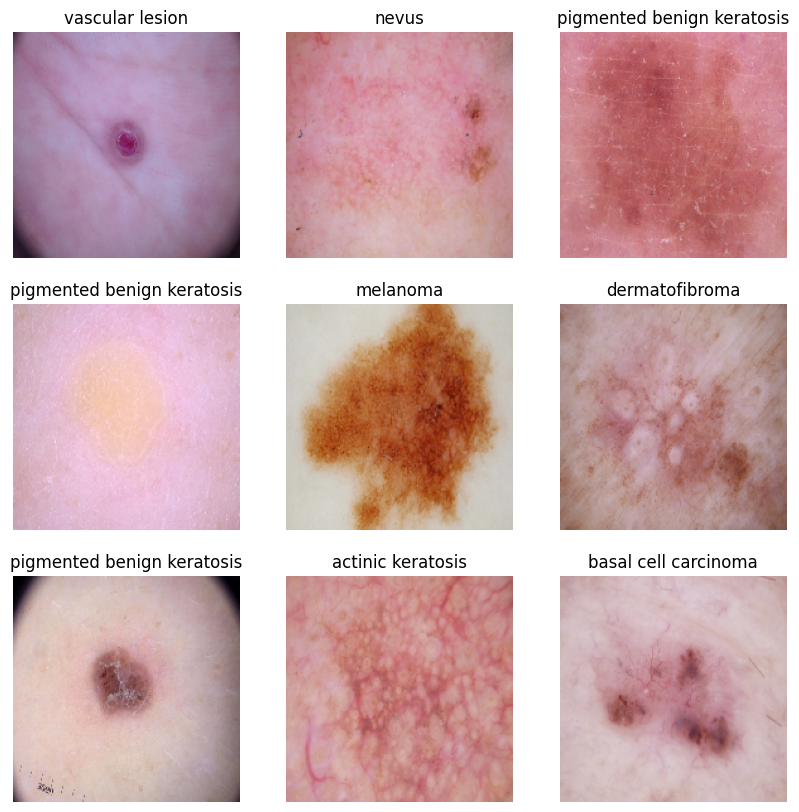

In [10]:
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model - Model 1
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,301,673 (12.59 MB)

 Trainable params: 3,301,673 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.1796 - loss: 2.4554 - val_accuracy: 0.2752 - val_loss: 1.9714
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.2712 - loss: 1.9269 - val_accuracy: 0.2707 - val_loss: 1.9448
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3503 - loss: 1.7849 - val_accuracy: 0.4072 - val_loss: 1.6269
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4331 - loss: 1.6096 - val_accuracy: 0.5034 - val_loss: 1.4469
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5238 - loss: 1.3632 - val_accuracy: 0.5235 - val_loss: 1.5066
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5509 - loss: 1.2796 - val_accuracy: 0.5459 - val_loss: 1.3997
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5740 - loss: 1.2549 - val_accuracy: 0.5414 - val_loss: 1.3469
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6236 - loss: 1.0956 - val_accuracy: 0.5324 

### Visualizing training results Model 1

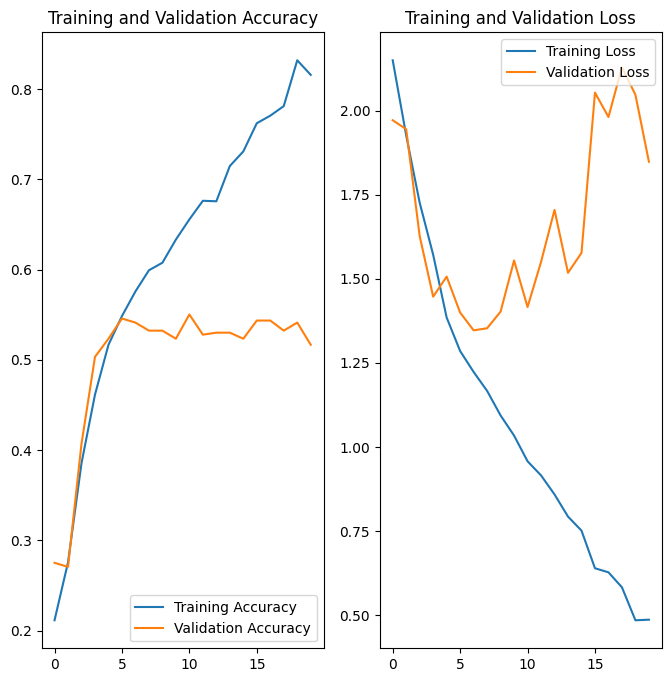

In [16]:
# visualizating the accuracy and loss of train and test

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Accuracy

- Training accuracy is steadily increasing using training data
- Validation accuracy is not showing similar results, it increases in the begining and settles around 5 epoch and does not rise up again, showing overfitting signs

#### Loss
- The training loss shows a steady decline
- The validation loss shows decline initially but it shoots up again around epoch 5 which indicates overfitting case

#### Recommendation

- We can try the early stopping feature to stop further training of model
- Increasing the data set, now as we have around 2k images. A varied image list will provide a generic learning.
- Data augmentaiton, using image augmentation techique like roation, flipping, cropping etc to get more features of the images.

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.1, fill_mode='nearest'),
    tf.keras.layers.Resizing(img_height, img_width)  # Ensure the output size is consistent
])

train_ds_augmented = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)


(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)


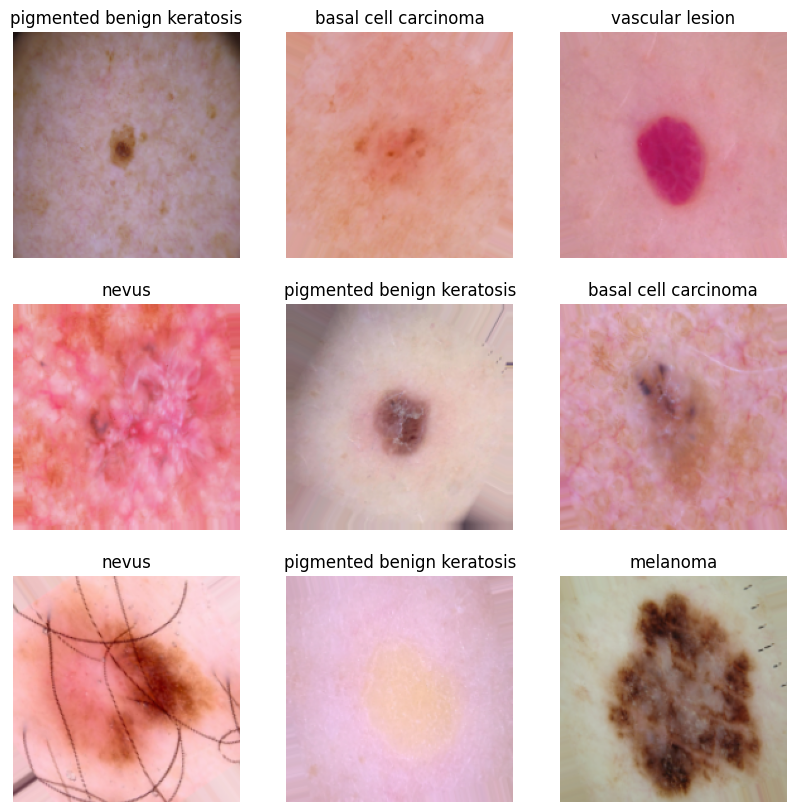

In [18]:
# visualize how your augmentation strategy works for one instance of training image.

# Take one batch from the dataset

plt.figure(figsize=(10, 10))
for images, labels in train_ds_augmented.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        print(images[i].shape)
plt.show()


### Create the model, compile and train the model, Model 2


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes
])

### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy,
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.2721 - loss: 1.9658 - val_accuracy: 0.4519 - val_loss: 1.5947
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4306 - loss: 1.5970 - val_accuracy: 0.4653 - val_loss: 1.5876
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4792 - loss: 1.4754 - val_accuracy: 0.5391 - val_loss: 1.4017
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5096 - loss: 1.4004 - val_accuracy: 0.4653 - val_loss: 1.5277
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5245 - loss: 1.3469 - val_accuracy: 0.5168 - val_loss: 1.4208
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5283 - loss: 1.3339 - val_accuracy: 0.4698 - val_loss: 1.4753
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5148 - loss: 1.3301 - val_accuracy: 0.5369 - val_loss: 1.3390
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5257 - loss: 1.3251 - val_accuracy: 0.4855 - v

### Visualizing the results, Model 2

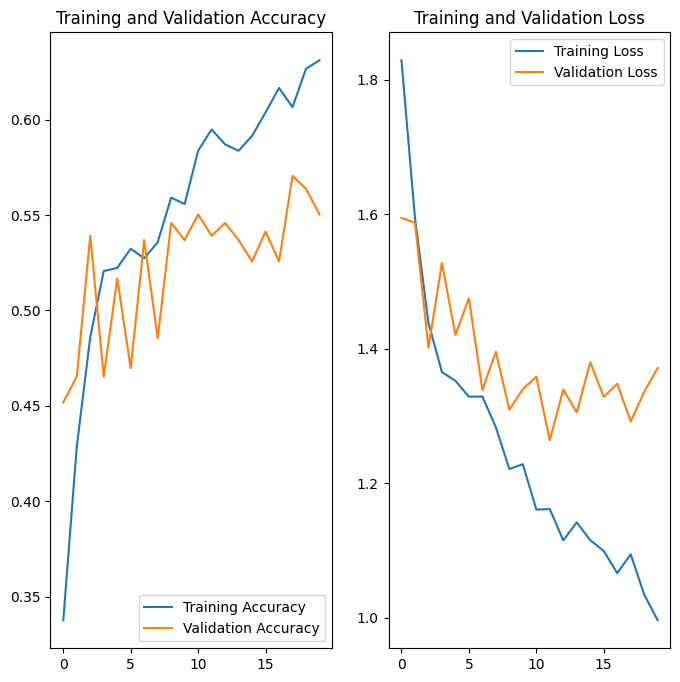

In [22]:
# visualizating the accuracy and loss of train and test after augmentation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Accuracy

- Training accuracy is steadily increasing using training data
- Validation accuracy is fully not following the training set, but it is better than the previous model

#### Loss
- The training loss shows a steady decline
- The validation loss shows decline initially but it shoots up a bit before epoch 10. The loss is much closer to training loss, which shows the overfitting is bit handled with the approach

#### Recommendation

- We will check the class variation of various category and process that further

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

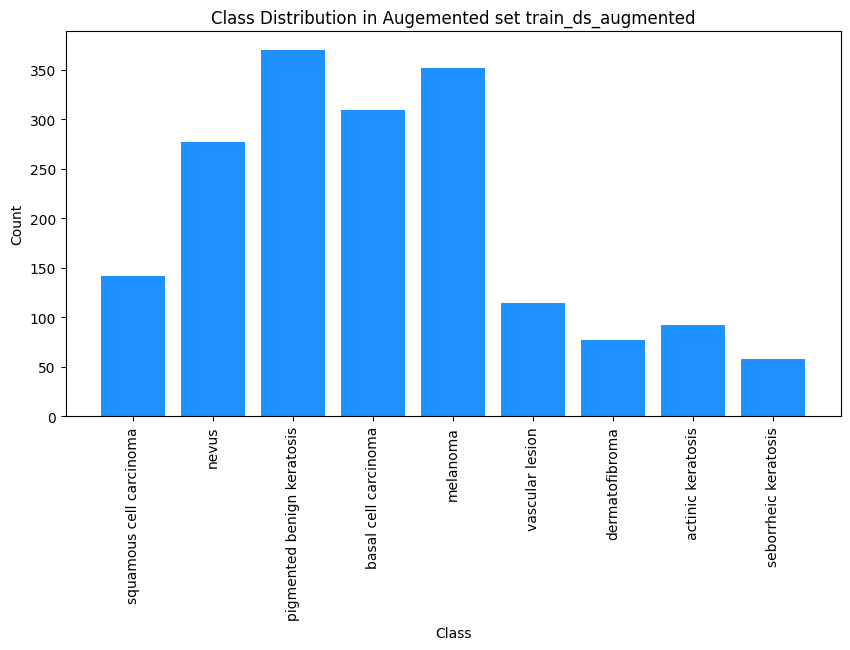

In [23]:
## Visualizing the distribution of various classes

import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter


def count_classes(dataset):
    class_counts = Counter()
    for _, labels in dataset:
        class_counts.update(labels.numpy())
    return class_counts

class_counts = count_classes(train_ds_augmented)


def plot_class_distribution(class_counts, class_names):
    classes = [class_names[i] for i in class_counts.keys()]
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts,color='dodgerblue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution in Augemented set train_ds_augmented')
    plt.xticks(rotation=90)
    plt.show()

plot_class_distribution(class_counts, class_names)



#### Write your findings here:
#### - Which class has the least number of samples?
- The least numner is in seborrheic keratosis category
#### - Which classes dominate the data in terms proportionate number of samples?
- The top3 are below
- pigmented benign keratosis
- melanoma
- basal cell carcinoma


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
#  Install Augmentor
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
# Setting up Augmentor to create copies

path_to_training_dataset="/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E647E321450>: 100%|██████████| 500/500 [00:22<00:00, 21.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E649258A490>: 100%|██████████| 500/500 [00:18<00:00, 26.84 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E647E3E4E10>: 100%|██████████| 500/500 [00:17<00:00, 28.09 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E649258BDD0>: 100%|██████████| 500/500 [01:15<00:00,  6.62 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7E647E323010>: 100%|██████████| 500/500 [01:19<00:00,  6.26 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E647E33BE10>: 100%|██████████| 500/500 [00:18<00:00, 27.28 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E647E2A3410>: 100%|██████████| 500/500 [00:40<00:00, 12.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E647E30FA50>: 100%|██████████| 500/500 [00:19<00:00, 25.38 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E647E48FB10>: 100%|██████████| 500/500 [00:17<00:00, 27.94 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
# checking the file content, countwise after augmentor
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
# Getting the file path list after augmentor
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029460.jpg_681fa008-d0d4-4466-88d7-72da1f3728c0.jpg',
 '/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_39005504-84fb-43d8-a6e2-6e2ecec8277b.jpg',
 '/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027829.jpg_1102d14a-5e8a-4578-a4df-0b80e3c7b3c7.jpg',
 '/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028941.jpg_f3651a68-442e-4bf5-a116-515c56378994.jpg',
 '/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/ac

In [28]:
# Getting the classes after augmentor

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [29]:
# Creating a dataframe with file path and category

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [30]:
# Getting the file path list before augmentor
path_list_original = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_original


['/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0030142.jpg',
 '/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0028990.jpg',
 '/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026765.jpg',
 '/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0028063.jpg',
 '/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026625.jpg',
 '/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029840.jpg',
 '/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic 

In [31]:
# Creating a dataframe with file path and category before Augmentor

# List first-level directories
first_level_dirs = [d for d in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, d))]

# Collect files from first-level directories only
lesion_list_original = []
for d in first_level_dirs:
    files = glob.glob(os.path.join(data_dir_train, d, '*.jpg'))
    lesion_list_original.extend([os.path.basename(os.path.dirname(f)) for f in files])

In [32]:
# Creating a dataframe before Augmentor
dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

In [33]:
# Concatinating both the dataframe
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [34]:
# Printing the value count
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [36]:
# Setting the values for the images after Augmentor for training set

data_dir_train="/content/gdrive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [37]:
# Setting the values for the images after Augmentor for validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization), Model 3

In [38]:
## model creation code
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## Model compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy,
              metrics=['accuracy'])

#### Train your model

In [40]:
epochs = 30
## Your code goes here, use 30 epochs.
history = history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 234ms/step - accuracy: 0.1888 - loss: 2.1227 - val_accuracy: 0.3222 - val_loss: 1.9560
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.4082 - loss: 1.5458 - val_accuracy: 0.4536 - val_loss: 1.4468
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.4746 - loss: 1.3875 - val_accuracy: 0.4967 - val_loss: 1.3784
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.4943 - loss: 1.3330 - val_accuracy: 0.5108 - val_loss: 1.2855
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.5226 - loss: 1.2425 - val_accuracy: 0.5241 - val_loss: 1.2173
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.5383 - loss: 1.2118 - val_accuracy: 0.5412 - val_loss: 1.2016
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.5510 - loss: 1.1666 - val_accuracy: 0.5620 - val_loss: 1.1728
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.5598 - loss: 1

#### Visualize the model results, model 3

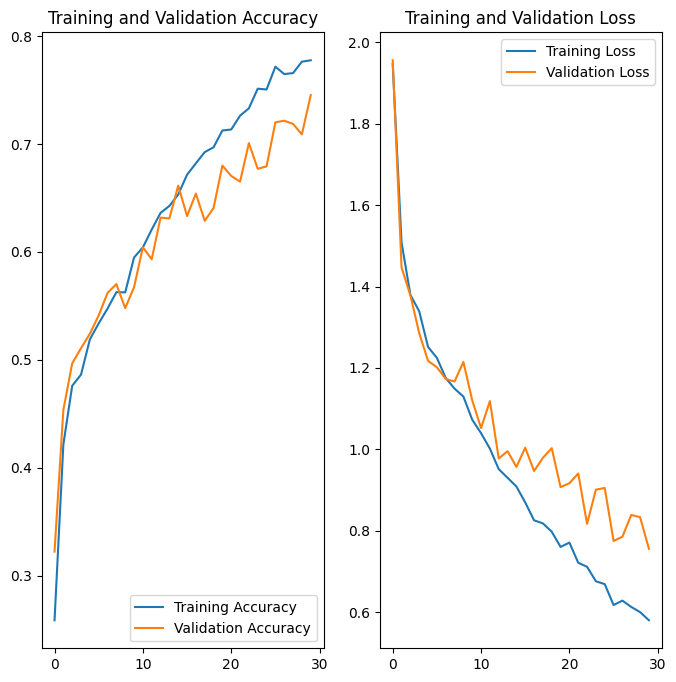

In [41]:
# Visualizing the accuracy and loss after Augmentor

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis
- The overfitting and underfitting problem is handled much better now and the above graph shows the accuracy almost similar in both cases. Also the loss the going down in both cases. The validation accuracy is 74, but this also has a 30 epoch which is bit higher comapred to previous 20 epochs. The training accuracy is also bumped up to 77.

